In [6]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
import numpy.linalg as LA
from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel, NonHermitianHamiltonianOBC

import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, topology_verifier, obtain_phase_center_and_number

In [7]:
class Chern2DOBC(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 2

    def get_n_dim(self):
        return 2

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['vx'], kwargs['vy'], kwargs['tx'], kwargs['ty'], kwargs['gamma'], kwargs['m']

    def get_kpoints(self):
        n_points = 3
        kpoints = list()
        for kx in np.linspace(0,np.pi,n_points):
            for ky in np.linspace(0,np.pi,n_points):
                kpoints.append([kx, ky])
        return kpoints

    def initiate(self):
        tx = ty = vx = vy = 1.
        m = 2*np.random.random() + 1.
        gamma = 0.5*np.random.random()
        self.parameters = vx, vy, tx, ty, gamma, m

    def is_real_line_gap(self):
        for k in self.get_kpoints():
            hk = self.get_Hamiltonian(k)
            Es = LA.eigvals(hk)
            #print(np.abs(np.real(Es)))
            if np.any(np.abs(np.real(Es - self.E_ref)) < 1e-3):
                return False
        return True     

    def get_Hamiltonian(self, k):
        kx, ky= k
        hk = np.zeros((2,2), dtype=complex)
        vx, vy, tx, ty, gamma, m = self.parameters

        kx = kx - 1j*gamma/vx
        ky = ky - 1j*gamma/vy
        
        hk = hk + (vx*np.sin(kx) + 1j*gamma)*sigma_x \
            + (vy*np.sin(ky) + 1j*gamma)*sigma_y \
            + (m - tx*np.cos(kx) - ty*np.cos(ky))*sigma_z

        hk = hk - self.E_ref*sigma_0
        
        return hk
    
class Chern2DOBCPerturbation(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 2

    def get_n_dim(self):
        return 2

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['vx'], kwargs['vy'], kwargs['tx'], kwargs['ty'], kwargs['gamma'], kwargs['m']

    def get_kpoints(self):
        n_points = 3
        kpoints = list()
        for kx in np.linspace(0,np.pi,n_points):
            for ky in np.linspace(0,np.pi,n_points):
                kpoints.append([kx, ky])
        return kpoints

    def initiate(self):
        tx = ty = vx = vy = 1.
        m = 2*np.random.random() + 1.
        gamma = 0.5*np.random.random()
        self.parameters = vx, vy, tx, ty, gamma, m

    def is_real_line_gap(self):
        for k in self.get_kpoints():
            hk = self.get_Hamiltonian(k)
            Es = LA.eigvals(hk)
            #print(np.abs(np.real(Es)))
            if np.any(np.abs(np.real(Es - self.E_ref)) < 1e-3):
                return False
        return True     

    def get_Hamiltonian(self, k):
        kx, ky= k
        hk = np.zeros((2,2), dtype=complex)
        vx, vy, tx, ty, gamma, m = self.parameters

        kx = kx - 1j*gamma/vx
        ky = ky - 1j*gamma/vy
        
        hk = hk + (vx*np.sin(kx) + 1j*gamma)*sigma_x \
            + (vy*np.sin(ky) + 1j*gamma)*sigma_y \
            + (m - tx*np.cos(kx) - ty*np.cos(ky))*sigma_z

        hk = hk - self.E_ref*sigma_0
        
        return 0.1*hk

In [8]:
#name = "Chern2D"
gap_type="real line"
E_ref = 0.
hamiltonian_model = Chern2DOBC(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_model, gap_type=gap_type)

n_sample = 200
_models, vs = generator.generate_models(n_sample)
Qs, vs = generator.generate(n_sample)
n = generator.get_n()

models = list()
for model in _models:
    if model.is_real_line_gap():
        models.append(model)

print("Number of samples: ", len(models))

Number of samples:  198


In [9]:
cluster = Cluster(similarity_function=topology_comparator, verbose=False)
center_indices, group_number = cluster.fit(models)
print(group_number)
print("The number of centers: ", len(center_indices))

[104  94]
The number of centers:  2


In [10]:
print("Gap type: ", gap_type)
hamiltonian_perturbation = Chern2DOBCPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations)
print("The number of phases: ", len(new_group_number))
print(new_group_number)

Gap type:  real line
The number of phases:  2
[104, 94]


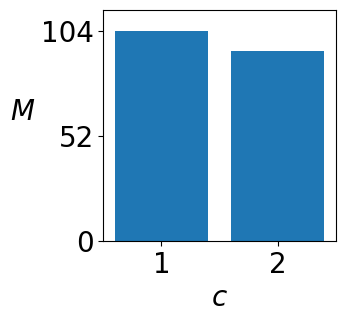

In [11]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

In [17]:
classifier = Classifier(similarity_func=topology_comparator, cluster_centers=[models[index] for index in new_center_indices])
n1 = 51
n2 = 51
ms = np.linspace(1.01,3,n1)
gammas = np.linspace(0.01,0.5,n2)
v_list = np.zeros((n1,n2))

print(gap_type)

for i in range(n1):
    for j in range(n2):
        hamiltonian = Chern2DOBC(E_ref=0.)
        hamiltonian.set_parameters(tx=1., ty=1., vx=1., vy=1., m=ms[i], gamma=gammas[j])
        if hamiltonian.is_real_line_gap():
            _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type="real line")
            #v_list.append(1)
            v_list[i,j] = classifier.classify(_model)
    print(i)

real line
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


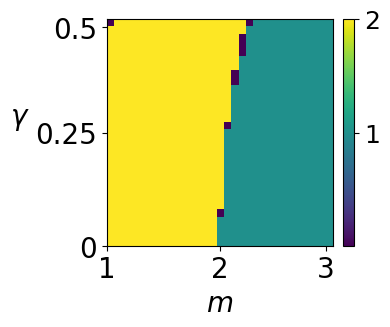

In [18]:
n1, n2 = v_list.shape

plt.figure(figsize=(4,4))
plt.imshow(np.transpose(v_list), origin='lower',extent = [0,n1,0,n2])
plt.xlabel(r"$m$",fontsize=20)
plt.ylabel(r"$\gamma$",fontsize=20, rotation=0, horizontalalignment='right')
plt.xticks([0, n1/2, n1-1],[r"1", r"2", r"3"],fontsize=20)
plt.yticks([0, n2/2, n2-1],[r"0", r"0.25", r"0.5"], fontsize=20)

cb = plt.colorbar(ticks=range(1, len(center_indices)+1), fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

In [20]:
from tools import save_data, save_data_M

name = "2D_Chern_OBC_real"
save_data(new_center_indices, new_group_number, "fig2_{0}_group_number.h5".format(name))
save_data_M(v_list, "fig2_{0}_phase_diagram.h5".format(name))
print(name)

2D_Chern_OBC_real
